# Why ML models with good predictive metrics are not necessarily good causal models.

Based on [Why Prediction Metrics are Dangerous For Causal Models](https://matheusfacure.github.io/python-causality-handbook/Prediction-Metrics-For-Causal-Models.html)

## Generate Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's say we have covariates $X$ with a high predictive power and also non-confounders $W$ that only impact the outcome of the treatment. Let's say that treatment $T_i$ has a low predictive power as well as $W_i$:

$$
Y_i = g(X_i) + f(T_i, W_i) + e_i
$$

In [3]:
dataset_size = 1000000
n_x = 20
n_w = 10

np.random.seed(1854950329)

X = np.random.normal(loc=1, scale=10, size=(dataset_size, n_x))
W = np.random.normal(loc=1, scale=10, size=(dataset_size, n_w))

# Define linear g and f functions from the equation above:
g_coefs = np.random.uniform(-1, 1, (n_x, 1))
f_coefs = np.random.uniform(-1, 1, (n_w, 1))

noise = np.random.normal(loc=1, scale=0.1)
T = np.random.normal(loc=10, scale=2, size=(dataset_size, 1)) # No counfounders!
Y = 20*X.dot(g_coefs) + T + T*W.dot(f_coefs) + noise

x_columns = [f'x{i}' for i in range(n_x)]
w_columns = [f'w{i}' for i in range(n_w)]
data = pd.concat([
    pd.DataFrame(X, columns=x_columns),
    pd.DataFrame(W, columns=w_columns),
], axis='columns').assign(Y=Y, T=T)

Text(0.5, 1.0, '$SE = \\frac{\\sigma}{\\sqrt{N}}$')

/home/stepan/.cache/pypoetry/virtualenvs/ml-practice-siGx9brc-py3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/stepan/.cache/pypoetry/virtualenvs/ml-practice-siGx9brc-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


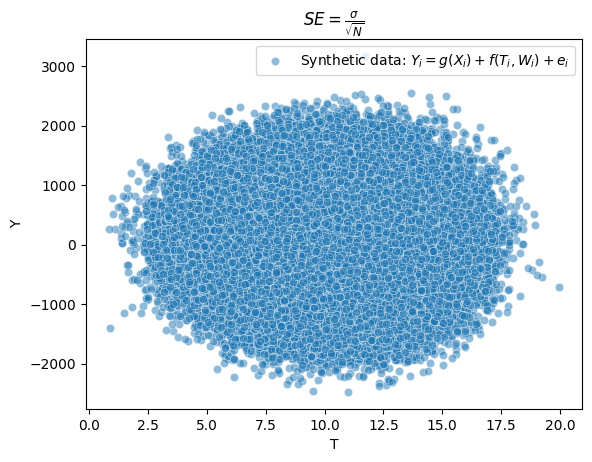

In [14]:
sns.scatterplot(x=T[:, 0], y=Y[:, 0], alpha=0.5, label="Synthetic data: $Y_i = g(X_i) + f(T_i, W_i) + e_i$")
plt.xlabel("T")
plt.ylabel("Y")
plt.title("$SE = \\frac{\\sigma}{\\sqrt{N}}$")

## Break Data into Train/Test

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.5)
train.shape, test.shape

((500000, 32), (500000, 32))

## Train OLS models on two features sets

Let's train two models:
1. The first on high-predictive, but not affecting treatment heterogeneity ($X$)
2. The second on low-predictive, but affecting treatment heterogeneity ($W$)

In [23]:
from sklearn.linear_model import LinearRegression

model_x = LinearRegression().fit(train[x_columns], train.Y)
model_w = LinearRegression().fit(train[w_columns], train.Y)

## Compare Predictive Power

In [26]:
from sklearn.metrics import r2_score

(
    r2_score(test.Y, model_x.predict(test[x_columns])),
    r2_score(test.Y, model_w.predict(test[w_columns])),
)

(0.8936335148057702, 0.10182852904098338)

**NOTE** The second is much worse! (almost 9 times)

# Let's Try Causal Model

In [42]:
model_denoise = LinearRegression().fit(train[x_columns + w_columns], train.Y)
train['Y_res'] = train.Y - model_denoise.predict(train[x_columns + w_columns])
test['Y_res'] = test.Y - model_denoise.predict(test[x_columns + w_columns])

In [48]:
from catboost import CatBoostRegressor

model_x_res = CatBoostRegressor(verbose=False).fit(train[x_columns + ['T']], train.Y_res)
model_w_res = CatBoostRegressor(verbose=False).fit(train[w_columns + ['T']], train.Y_res)

In [49]:
(
    r2_score(test.Y_res, model_x_res.predict(test[x_columns + ['T']])),
    r2_score(test.Y_res, model_w_res.predict(test[w_columns + ['T']])),
)

(-0.006806260446441614, 0.9950760562379267)